<a href="https://colab.research.google.com/github/tubes886/sustainable-farming/blob/main/Sustainable_Farming_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Notebook setup

!gdown --id 1DgOZ56YruuUmHRD7hZNJNM39mlbRGApp # sample metadata
!gdown --id 1Df7xqxCbENHB4oeovf2dYpx9_3dyYEYv # 16S_counts
!gdown --id 15SQ9C5r_ExRGTiX3zehu959lKW_LrrBp # bacteria_counts
!gdown --id 1yeBvAHeULU4Vk_TeAtWuF8kZRhyNCNa- # sequence_to_species_dict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

metadata = pd.read_table('sample_metadata.tsv')
metadata.index = ['farm_%i' %i for i in range(len(metadata))]

sequences_counts = pd.read_table('16S_counts.tsv')
sequences_counts.index = ['farm_%i' % i for i in range(len(sequences_counts))]

bacteria_counts = pd.read_table('bacteria_counts.tsv')
bacteria_counts.index = ['farm_%i' % i for i in range(len(bacteria_counts))]
cols = list(bacteria_counts.columns)
np.random.seed(42)
np.random.shuffle(cols)
bacteria_counts = bacteria_counts[cols]
sequence_to_species_dict = np.load('sequence_to_species_dict.npy', allow_pickle=True).item()

bacteria_counts = bacteria_counts.drop(['Unnamed: 0'], axis=1) 

Downloading...
From: https://drive.google.com/uc?id=1DgOZ56YruuUmHRD7hZNJNM39mlbRGApp
To: /content/sample_metadata.tsv
100% 64.3k/64.3k [00:00<00:00, 1.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Df7xqxCbENHB4oeovf2dYpx9_3dyYEYv
To: /content/16S_counts.tsv
49.3MB [00:00, 60.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=15SQ9C5r_ExRGTiX3zehu959lKW_LrrBp
To: /content/bacteria_counts.tsv
3.84MB [00:00, 17.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yeBvAHeULU4Vk_TeAtWuF8kZRhyNCNa-
To: /content/sequence_to_species_dict.npy
100% 1.17M/1.17M [00:00<00:00, 5.43MB/s]


In [ ]:
metadata.head()

,crop_yield,sample_type,country,timestamp
farm_0,0.68,barley soil sample,GAZ:Australia,2011-3-26
farm_1,1.00,barley soil sample,GAZ:Australia,2011-11-22
farm_2,0.87,barley soil sample,GAZ:Australia,2011-6-10
farm_3,0.68,barley soil sample,GAZ:Australia,2011-11-3
farm_4,0.67,barley soil sample,GAZ:Australia,2011-3-26


[the `histplot` documentation](https://seaborn.pydata.org/generated/seaborn.histplot.html)


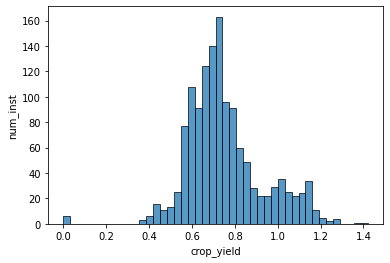

In [ ]:
# Histoplot
ax = sns.histplot(data=metadata['crop_yield'])
ax.set(xlabel='crop_yield', ylabel='num_inst')
plt.show()

In [ ]:
# Bacteria composition dataset
bacteria_counts.head()

,Xanthomonadales,Glutamicibacter,Geobacillus,Rickettsia,Armatimonadales,Phaselicystis,Gammaproteobacteria,Candidatus Berkiella,Lawsonella,Hungateiclostridiaceae,Herminiimonas,Rhodococcus,Pla4 lineage,BD2-11 terrestrial group,IS-44,Paenibacillus,Microbacteriaceae,Subgroup 10,Arcobacter,67-14,Modestobacter,Anaeromyxobacter,Streptomyces,Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium,Silvanigrella,Prosthecobacter,GOUTA6,Jatrophihabitans,Rubrobacter,Acidothermus,Gemmatimonadaceae,Alphaproteobacteria,Clostridium sensu stricto 12,Group 1.1c,Sphingomonadaceae,Dokdonia,Bordetella,Dokdonella,Dongia,Chryseolinea,...,Rhizobiaceae,Woesearchaeales,Rothia,Frankiaceae,Streptosporangium,Streptococcus,Cupriavidus,R7C24,Ruminiclostridium,Alteromonadaceae,Psychromonas,Steroidobacter,Geminicoccaceae,Absconditabacteriales (SR1),Kouleothrix,Polycyclovorans,Chthoniobacteraceae,Hirschia,Cystobacter,NS9 marine group,Opitutales,Rhodocyclaceae,Luteibacter,Kibdelosporangium,Candidatus Arthromitus,Bdellovibrio,Micropepsaceae,Bacillaceae,Polyangiales,Lentimicrobiaceae,Dyella,Proteobacteria,C0119,Vampirovibrionaceae,Abditibacterium,Arenimonas,Blastococcus,Haemophilus,Peptoclostridium,Beutenbergiaceae
farm_0,0.0,0.0,0.0,0.0,0.0,2.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,259.0,0.0,0.0,0.0,30.0,18.0,46.0,85.0,1517.0,0.0,0.0,0.0,27.0,0.0,247.0,57.0,5.0,0.0,0.0,176.0,0.0,0.0,0.0,0.0,0.0,...,77.0,0.0,0.0,100.0,83.0,0.0,611.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
farm_1,156.0,0.0,0.0,0.0,0.0,77.0,236.0,10.0,0.0,0.0,0.0,0.0,47.0,15.0,0.0,100.0,0.0,101.0,0.0,489.0,3.0,164.0,65.0,57.0,0.0,0.0,0.0,89.0,0.0,274.0,57.0,77.0,0.0,0.0,11.0,0.0,0.0,122.0,54.0,0.0,...,14.0,0.0,0.0,31.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0,18.0,0.0,19.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,13.0,101.0,0.0,80.0,0.0,0.0,0.0,32.0,0.0,15.0,17.0,94.0,0.0,0.0,0.0
farm_2,133.0,0.0,0.0,7.0,95.0,60.0,1164.0,13.0,0.0,4.0,49.0,7.0,18.0,0.0,0.0,94.0,16.0,66.0,0.0,114.0,0.0,60.0,27.0,109.0,0.0,5.0,0.0,68.0,0.0,191.0,35.0,35.0,0.0,0.0,0.0,0.0,0.0,133.0,420.0,0.0,...,2.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,533.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,14.0,0.0,56.0,138.0,0.0,29.0,0.0,0.0,0.0,66.0,0.0,9.0,16.0,14.0,0.0,0.0,0.0
farm_3,199.0,0.0,0.0,0.0,0.0,95.0,274.0,0.0,0.0,0.0,5.0,8.0,71.0,11.0,0.0,140.0,1.0,82.0,0.0,351.0,20.0,187.0,28.0,1.0,0.0,10.0,0.0,89.0,19.0,488.0,75.0,132.0,0.0,0.0,16.0,0.0,0.0,98.0,40.0,0.0,...,0.0,0.0,0.0,9.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,9.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,18.0,195.0,0.0,86.0,0.0,0.0,0.0,73.0,0.0,2.0,15.0,54.0,0.0,0.0,1.0
farm_4,0.0,0.0,0.0,0.0,0.0,0.0,2265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,416.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1712.0,0.0,0.0,0.0,0.0,2220.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Removing features/bacteria that are low-prevalence, aka singleton

low_prev_bacteria = []
bacteria = bacteria_counts.columns
for b in bacteria:
  if sum(bacteria_counts[b]>0)<25:  # If bacteria 'b' is a singleton,

    # Adding bacteria 'b' to the list of singletons
    low_prev_bacteria = low_prev_bacteria + [b]
    
n_low_prevalence = len(low_prev_bacteria)
# Counting the total number of singletons
print('%i bacteria are low prevalence.' % n_low_prevalence)

# Dropping the columns specified from the bacteria_counts dataframe
bacteria_counts_no_low_prev = bacteria_counts.drop(low_prev_bacteria, axis=1)
bacteria_counts_no_low_prev.head()

To log-normalize a number N: $N_{norm} = log(N+1)$.
[The documentation for the function](https://numpy.org/doc/stable/reference/generated/numpy.log.html)



In [ ]:
# Log-normalizing data on the bacteria_counts_no_low_prev dataframe, this is because we want to see the relative changes in the data
bacteria_counts_lognorm = np.log(bacteria_counts_no_low_prev + 1)
print(bacteria_counts_lognorm) 

In [ ]:
bacteria_counts_lognorm.to_csv('bacteria_counts_lognorm.csv')

In [ ]:
# Unsupervised learning method- hierarchical clustering, to visualize data and features

f = sns.clustermap(bacteria_counts_lognorm)
f.ax_heatmap.set_ylabel('Farm idx')
f.ax_heatmap.set_xlabel('Bacteria Species')
plt.show()

In [ ]:
f = sns.clustermap(bacteria_counts_lognorm[:20])
f.ax_heatmap.set_ylabel('Farm idx')
f.ax_heatmap.set_xlabel('Bacteria Species')
plt.show()

Sequencing info [article](https://www.khanacademy.org/science/high-school-biology/hs-molecular-genetics/hs-biotechnology/a/dna-sequencing). 




In [ ]:
sequences_counts.head()

In [ ]:
# Converting sequence counts to terms of different bacteria because each sequences corresponds to a type of bacteria
bacteria_counts[bacteria_counts.columns[20::20]].head()

In [ ]:
# Transposing data for ease of use
sequences_counts_t = sequences_counts.transpose() 

# Creating new column "species" that corresponds to the species of a given sequence, using the sequences_to_species_dict dictionary
sequences_counts_t['species'] = [sequence_to_species_dict[i] for i in sequences_counts_t.index]

# Using the pandas "groupby" function to group sequences together by species
# Using the .sum() function to sum together the counts of the grouped sequences
summed_data = sequences_counts_t.groupby('species').sum()

# Re-transposing data
bacteria_counts = summed_data.transpose()
bacteria_counts.head()

In [ ]:
print('Shape of sequence_counts:', np.shape(sequences_counts))
print('Shape of bacteria_counts:', np.shape(bacteria_counts))

In [ ]:
bacteria_counts